In [1]:
import os

import numpy as np
from netCDF4 import Dataset
import pandas as pd
from datetime import datetime
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000) 

In [2]:
gsi_hofx_dir = "/work/noaa/wrfruc/span/jedi_summer_retro/gsi_prepbufr_analysis/2023061012/anal_conv_dbz_gsi"
gsi_hofx_suffix = "conv_t_01.nc4"
#gsi_hofx_dir = "/work/noaa/wrfruc/span/jedi_summer_retro/gsi_prepbufr_analysis/2023061012/anal_conv_dbz_gsi_winds287"
#gsi_hofx_suffix = "conv_uv_01.nc4"
#gsi_hofx_dir = "/work/noaa/wrfruc/span/jedi_summer_retro/gsi_prepbufr_analysis/2023061012/anal_conv_dbz_gsi_humidity187"
#gsi_hofx_suffix = "conv_q_01.nc4"
#gsi_hofx_dir = "/work/noaa/wrfruc/span/jedi_summer_retro/gsi_prepbufr_analysis/2023061012/anal_conv_dbz_gsi_surfacepressure187"
#gsi_hofx_suffix = "conv_ps_01.nc4"
#gsi_group = "Errinv_Final"
#gsi_group = "Observation"
gsi_group = "Obs_Minus_Forecast_adjusted"
#gsi_group2 = "Observation"
plot_hofx = False
jedi_hofx_dir = "/work/noaa/wrfruc/span/jedi_summer_retro/jedi_prepbufr_analysis/2024081318/hofx"
jedi_hofx_filename = "hofx_adpsfc_localwl.nc4"
jedi_varname = "airTemperature"
#jedi_hofx_filename = "hofx_adpsfc_winds_287.nc"
#jedi_varname = "windNorthward"
#jedi_hofx_filename = "hofx_adpsfc_specificHumidity_187.nc"
#jedi_varname = "specificHumidity"
#jedi_hofx_filename = "hofx_adpsfc_stationPressure_187.nc"
#jedi_varname = "stationPressure"
#jedi_group = "EffectiveError0"
#jedi_group = "ObsValue"
jedi_group = "hofx0"
jedi_group2 = "ObsValue"
plot_innov = True

reference_time = "2024-08-13_18:00:00"

colormap="coolwarm"

In [3]:
def read_gsi(file_dir, filename_suffix, groupname, is_hofx=False, flag=1):
    # List all files in the directory that match the pattern pe{proc}.conv_q_01.nc4
    hofx_files = [os.path.join(file_dir, f) for f in os.listdir(file_dir) if f.endswith(filename_suffix)]

    all_latitudes = np.empty((0,))
    all_longitudes = np.empty((0,))
    all_times = np.empty((0,))
    all_pressures = np.empty((0,))
    all_values = np.empty((0,))
    have_data = False

    # Loop over each file and extract the required data
    for index, file in enumerate(hofx_files):
        with Dataset(file, "r") as nc_file:
            # Read the relevant variables
            try:
                flags = nc_file.variables["Analysis_Use_Flag"][:]
                lats = nc_file.variables['Latitude'][:][flags == flag]
                lons = nc_file.variables['Longitude'][:][flags == flag]
                times = nc_file.variables['Time'][:][flags == flag]
                press = nc_file.variables['Pressure'][:][flags == flag]
                if is_hofx:
                    values = nc_file.variables[gsi_group2][:][flags == flag] - nc_file.variables[groupname][:][flags == flag]
                else:
                    values = nc_file.variables[groupname][:][flags == flag]
                if "Errinv" in groupname:
                    values = 1.0 / values
                if "conv_ps_" in filename_suffix:
                    values = values / 10.
                elif "conv_q_" in filename_suffix:
                    values = values * 1000.
                have_data = True
            except:
                have_data = False
                print(f"No data in file: {file}")

        if have_data:
            all_latitudes = np.append(all_latitudes, lats)
            all_longitudes = np.append(all_longitudes, lons)
            all_times = np.append(all_times, times)
            all_pressures = np.append(all_pressures, press)
            all_values = np.append(all_values, values)

    return all_latitudes, all_longitudes, all_times, all_pressures, all_values

In [4]:
def read_jedi(file_dir, filename, groupname, varname, flag=0):
    # Load the NetCDF file
    nc_file = os.path.join(file_dir, filename)
    nc_data = Dataset(nc_file, "r")

    # Extract latitude, longitude, and values
    flags = nc_data.groups["EffectiveQC0"].variables[varname][:]
    lats = nc_data.groups["MetaData"].variables["latitude"][:][flags == flag]
    lons = nc_data.groups["MetaData"].variables["longitude"][:][flags == flag]
    times = nc_data.groups["MetaData"].variables["dateTime"][:][flags == flag]
    #dtypes = nc_data.groups["ObsType"].variables[varname][:][flags == flag]
    press = nc_data.groups["MetaData"].variables["pressure"][:][flags == flag]
    if plot_innov:
        values = nc_data.groups["ObsValue"].variables[varname][:][flags == flag] - \
                 nc_data.groups[groupname].variables[varname][:][flags == flag]
    else:
        values = nc_data.groups[groupname].variables[varname][:][flags == flag]
    
    if varname in ["stationPressure", ]:
        values = values / 10.**3.
    elif varname in ["specificHumidity", ]:
        values = values * 1000

    return lats, lons, times, press, values

In [5]:
def find_duplicates(df):
    # Calculate absolute values of 'times'
    df['abs_times'] = df['times'].abs()
    
    # Sort dataframe by 'abs_times' within each group of 'lats' and 'lons'
    df_sorted = df.sort_values(by=['lats', 'lons', 'abs_times'])
    
    ## Drop duplicates based on 'lats' and 'lons', keeping the first occurrence (minimum abs_times)
    #df_unique = df_sorted.drop_duplicates(subset=['lats', 'lons'], keep='first')
    #
    ## Drop the 'abs_times' column
    #df_unique = df_unique.drop(columns=['abs_times'])
    #
    ## Sort dataframe by 'abs_times' within each group of 'lats' and 'lons'
    #df_sorted = df.sort_values(by=['lats', 'lons', 'times'])
    
    # Drop duplicates based on 'lats' and 'lons', keeping the first occurrence (minimum abs_times)
    df_unique = df_sorted.drop_duplicates(subset=['lats', 'lons', 'times'], keep='first')
    #df_dropped = df_sorted[df_sorted.duplicated(subset=['lats', 'lons', 'times'], keep='first')]
    
    # Sort by index
    df_unique = df_unique.drop(columns="abs_times").sort_index().reset_index(drop=True)

    df_array = df_unique.to_numpy()
    lats = df_array[:,0]
    lons = df_array[:,1]
    times = df_array[:,2]
    press = df_array[:,3]
    
    return lats, lons, times, press, df_unique

In [6]:
def find_overlaps(df1, df2, time_threshold=5):
    ## Merge two dataframes on 'lats', 'lons', and 'times'
    #merged = pd.merge(df1, df2, on=['lats', 'lons', 'times'], suffixes=('_df1', '_df2'), how='outer', indicator=True)
    #
    ## Split merged dataframe into overlaps and non-overlaps
    #overlaps = merged[merged['_merge'] == 'both'].drop(columns='_merge').reset_index(drop=True)
    #non_overlaps_df1 = merged[merged['_merge'] == 'left_only'].drop(columns='_merge').reset_index(drop=True)
    #non_overlaps_df2 = merged[merged['_merge'] == 'right_only'].drop(columns='_merge').reset_index(drop=True)
    #
    ## Print or return the results
    #print("Overlapped rows:")
    #print(overlaps.shape)
    #print("\nNon-overlapped rows in DataFrame 1:")
    #print(non_overlaps_df1)
    #print("\nNon-overlapped rows in DataFrame 2:")
    #print(non_overlaps_df2)
    
    # Merge dataframes on 'lats' and 'lons'
    df1['index'] = df1.index
    df2['index'] = df2.index
    merged = pd.merge(df1, df2, on=['lats', 'lons'], suffixes=('_df1', '_df2'), how='outer', indicator=True)
    
    # Filter based on time difference
    merged['time_diff'] = abs(merged['times_df1'] - merged['times_df2'])
    merged = merged[merged['time_diff'] < time_threshold]
    
    # Initialize lists to store overlapped and non-overlapped rows
    overlapped_rows = []
    used_rows_df2 = set()
    
    # Iterate through merged dataframe to find overlaps
    for index, row in merged.iterrows():
        lat_lon = (row['lats'], row['lons'])  # Create a tuple of lat and lon
        if lat_lon not in used_rows_df2:  # Check if lat and lon pair exists in used_rows_df2
            overlapped_rows.append({
                'lats': row['lats'],
                'lons': row['lons'],
                'times_df1': row['times_df1'],
                'press_df1': row['press_df1'],
                'values_df1': row['values_df1'],
                'times_df2': row['times_df2'],
                'press_df2': row['press_df2'],
                'values_df2': row['values_df2']
            })
            used_rows_df2.add(lat_lon)
    
    # Create dataframe for overlapped rows
    overlapped_df = pd.DataFrame(overlapped_rows)
    
    # Create dataframe for non-overlapped rows in df1
    non_overlapped_df1 = df1[~df1.index.isin(merged['index_df1'])]
    
    # Create dataframe for non-overlapped rows in df2
    non_overlapped_df2 = df2[~df2.index.isin(merged['index_df2'])]
    

    # Check for matches between non-overlapped rows of df1 and df2
    matched_df = pd.merge(non_overlapped_df1, non_overlapped_df2, on=['lats', 'lons'], suffixes=('_df1', '_df2')).reset_index(drop=True)
    
    # Identify unmatched rows in non_overlapped_df1 and non_overlapped_df2
    unmatched_df1 = non_overlapped_df1[~non_overlapped_df1.index.isin(matched_df["index_df1"])].drop(columns=["index"]).reset_index(drop=True)
    unmatched_df2 = non_overlapped_df2[~non_overlapped_df2.index.isin(matched_df["index_df2"])].drop(columns=["index"]).reset_index(drop=True)

    # Drop unnecessary columns
    df1.drop(columns=["index"])
    df2.drop(columns=["index"])
    non_overlapped_df1.drop(columns=["index"])
    non_overlapped_df2.drop(columns=["index"])

    # Print the resulting dataframes
    print(f"Matched Observations: {overlapped_df.shape[0]}")
    #print(overlapped_df)
    
    # Print unmatched rows
    print(f"\nGSI Unmatched Observations: {unmatched_df1.shape[0]}")
    if unmatched_df1.shape[0] > 0:
        print(unmatched_df1)
    
    print(f"\nJEDI Unmatched Observations: {unmatched_df2.shape[0]}")
    if unmatched_df2.shape[0] > 0:
        print(unmatched_df2)

    overlapped_df['diff_values'] = overlapped_df['values_df1'] - overlapped_df['values_df2']
    return overlapped_df, unmatched_df1, unmatched_df2

In [7]:
def obs_validation(df_gsi, df_jedi, time_threshold=5):
    if "wind" in jedi_varname:
        merged_df = pd.merge(df_gsi, df_jedi, on=['lats', 'lons'], suffixes=('_gsi', '_jedi'), how='inner')
    else:
        merged_df = pd.merge(df_gsi, df_jedi, on=['lats', 'lons', 'press'], suffixes=('_gsi', '_jedi'), how='inner')

    # Calculate time difference
    merged_df['times_diff'] = (merged_df['times_gsi'] - merged_df['times_jedi'])

    # Filter rows where time difference is within $time_threshold seconds
    merged_df = merged_df[merged_df['times_diff'].abs() < time_threshold]

    # Calculate value difference
    merged_df['diff_values'] = merged_df['values_gsi'] - merged_df['values_jedi']

    if "wind" in jedi_varname:
        final_df = merged_df[['lats', 'lons', 'times_jedi', 'press_gsi', 'values_gsi', 'press_jedi', 'values_jedi', 'diff_values']]
        final_df.columns = ['lats', 'lons', 'times', 'press_gsi', 'values_gsi', 'press_jedi', 'values_jedi', 'diff_values']
    else:
        final_df = merged_df[['lats', 'lons', 'press', 'times_jedi', 'values_gsi', 'values_jedi', 'diff_values']]
        final_df.columns = ['lats', 'lons', 'press', 'times', 'values_gsi', 'values_jedi', 'diff_values']

    return final_df

In [8]:
def variable_scatter(lons, lats, values, colormap="terrain", markersize=1.0, alpha=1.0,
                     minval=None, maxval=None, area=[-140, -50, 20, 60], clon=-95, clat=40,
                     system=None, varname=None, vartype=None, is_hofx=False, is_innov=False):
    fig = plt.figure(figsize=(20, 16))

    cartopy.config['data_dir'] = "/work2/noaa/wrfruc/span/natural_earth_data"
    projection = ccrs.LambertConformal(central_longitude=-97, central_latitude=40,
                                       standard_parallels=(clat-5, clat+5))
    #projection = ccrs.PlateCarree(central_longitude=0.0, globe=None)
    ax = plt.axes(projection=projection)
    ax.set_extent(area, crs=ccrs.PlateCarree())
    
    land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
    ax.add_feature(land, zorder=0)
    
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['water'])
    ax.add_feature(ocean, zorder=0)
    
    # Add coastlines
    coast = cfeature.NaturalEarthFeature(category='physical', scale='50m', name='coastline')
    ax.add_feature(coast, edgecolor='black', facecolor='none', linewidth=0.5)
    
    # Add country borders
    countries = cfeature.NaturalEarthFeature(category='cultural', scale='50m', name='admin_0_countries')
    ax.add_feature(countries, edgecolor='black', facecolor='none', linewidth=0.7)
    
    # Add state lines
    states = cfeature.NaturalEarthFeature(category='cultural', scale='50m', name='admin_1_states_provinces')
    ax.add_feature(states, edgecolor='gray', facecolor='none', linewidth=0.5)

    sc = ax.scatter(lons, lats, c=values, cmap=colormap, vmin=minval, vmax=maxval, transform=ccrs.PlateCarree(), s=markersize, alpha=alpha)

    # Calculate the min and max of the values array
    n_obs = values.shape[0]
    min_value = np.min(values)
    max_value = np.max(values)
    mean_value = np.mean(values)
    stdev_value = np.std(values)

    # Add text for the min and max values in the bottom left corner of the map
    text_str = f"Number of Obs: {n_obs:4}\nMin Value: {min_value:.4f} \
                 \nMax Value: {max_value:.4f}\nMean Value: {mean_value:.4f} \
                 \nStandard Deviation: {stdev_value:.4f}"
    ax.text(area[0] + 1, area[2] - 1, text_str, transform=ccrs.PlateCarree(),
            fontsize=18, verticalalignment='bottom', horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    
    # Add a colorbar at the bottom
    if "Errinv" in vartype:
        cblabel = system + " " + varname + " 1/" + vartype
    else:
        if is_hofx:
            cblabel = system + " " + varname + " HofX"
        elif is_innov:
            cblabel = system + " " + varname + " Innovation"
        else:
            cblabel = system + " " + varname + " " + vartype
    cbar = plt.colorbar(sc, label=cblabel, orientation='horizontal', shrink=0.8, aspect=50, pad=0.01)

In [9]:
# Plotting
def valication_scatter(valid_df, varname, var_prefix="HofX"):

    print(f"number validated obs: {valid_df.shape}")
    # Calculate R-squared
    r_squared = r2_score(valid_df['values_gsi'], valid_df['values_jedi'])
    # Fit linear regression model
    slope, intercept = np.polyfit(valid_df['values_gsi'], valid_df['values_jedi'], 1)
    
    plt.figure(figsize=(16, 12))
    plt.scatter(valid_df['values_gsi'], valid_df['values_jedi'], color='blue', label='Validation Plot')
    plt.plot([valid_df['values_gsi'].min(), valid_df['values_gsi'].max()], 
             [valid_df['values_gsi'].min(), valid_df['values_gsi'].max()], 
             color='red', label='1:1 Line')
    plt.plot(valid_df['values_gsi'], slope * valid_df['values_gsi'] + intercept, 
             color='red', linestyle=':', label=f'$y = {slope:.2f}x + {intercept:.2f}$')
    plt.xlabel(var_prefix+'_gsi')
    plt.ylabel(var_prefix+'_jedi')
    plt.title(f'Validation Plot: GSI vs JEDI\n$R^2$ = {r_squared:.2f}')
    plt.legend()
    plt.grid(True)

Shape of GSI obs: (2070, 5)
Shape of JEDI obs: (2135, 5)
Matched Observations: 1789

GSI Unmatched Observations: 121
          lats        lons  times     press    values
0    39.130001  263.329987 -480.0   96431.0  0.411267
1    40.779999  248.029999 -360.0   85041.0  3.283441
2    32.139999  248.830002 -300.0   91867.0  0.263122
3    32.930000  248.570007 -300.0   95213.0  1.029341
4    32.950001  248.229996 -240.0   96008.0 -0.418786
5    33.470001  248.270004 -360.0   95813.0  2.302827
6    32.570000  277.010010 -300.0  100186.0  0.181649
7    33.529999  277.480011 -300.0   99547.0 -1.173043
8    38.349998  240.490005 -480.0   74072.0  3.812894
9    40.380001  239.429993 -300.0   84651.0 -1.482574
10   45.580002  256.470001 -240.0   90834.0  0.282594
11   47.709999  258.989990 -300.0   94569.0 -0.153536
12   47.750000  258.329987 -300.0   94302.0 -1.218207
13   37.279999  257.380005 -240.0   86263.0 -0.582831
14   39.360001  258.299988 -420.0   88543.0  0.356348
15   33.459999  279

/work/noaa/wrfruc/span/conda-envs/jedifv3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/local/scratch/span/19542488/ipykernel_3114632/2344800687.py:8: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(valid_df['values_gsi'], valid_df['values_jedi'], 1)


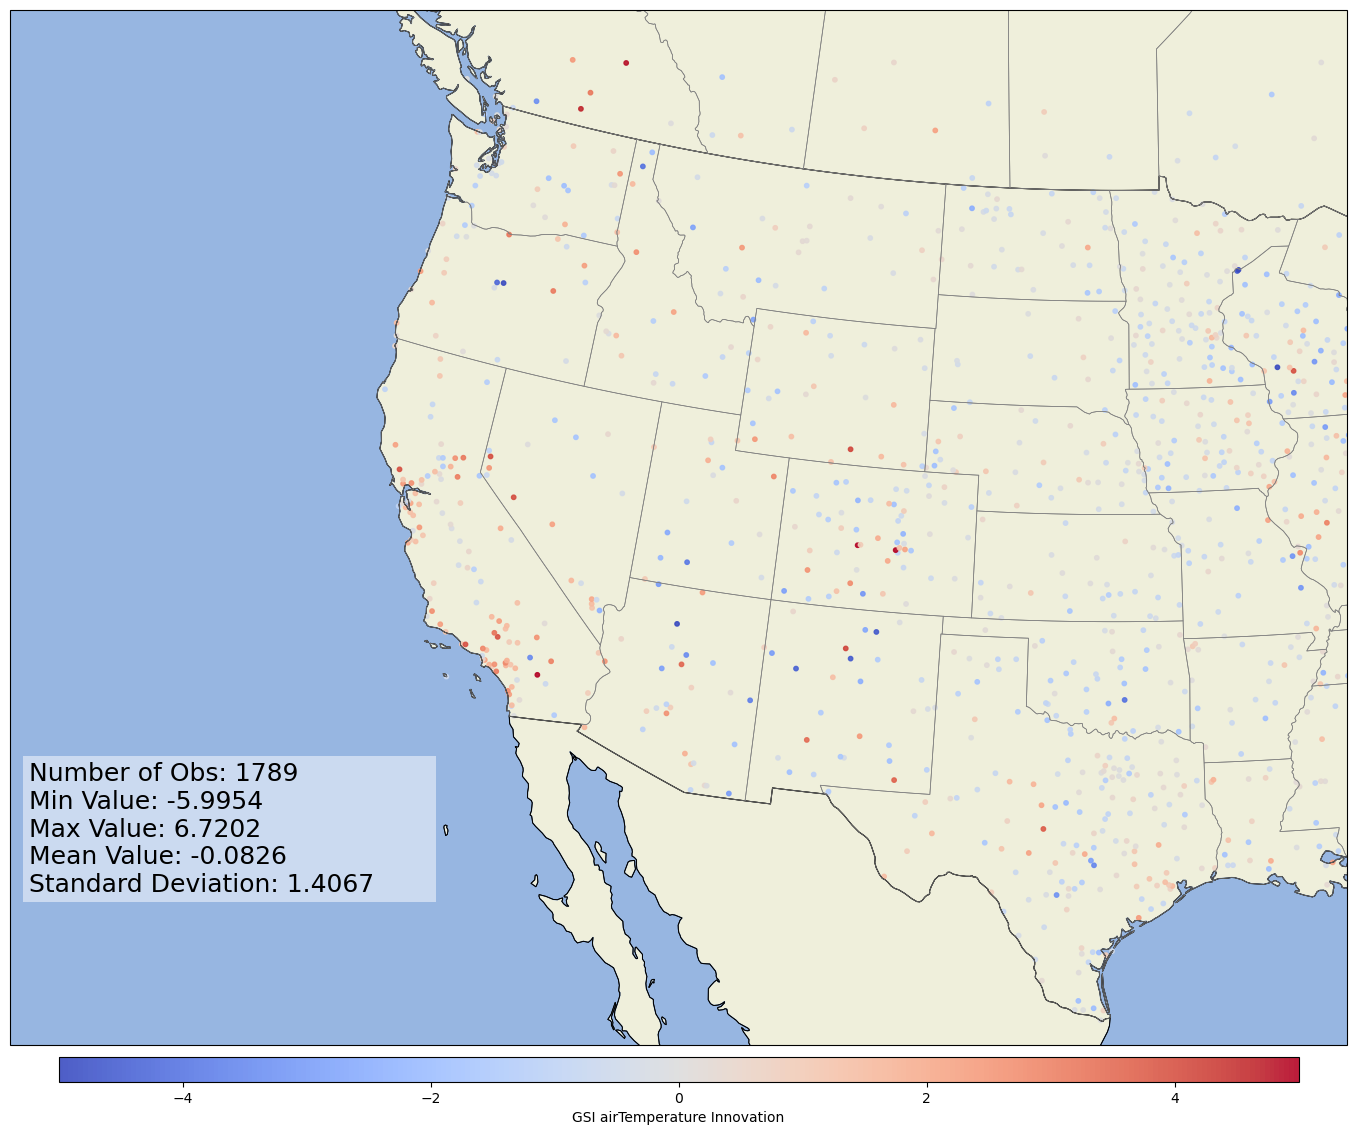

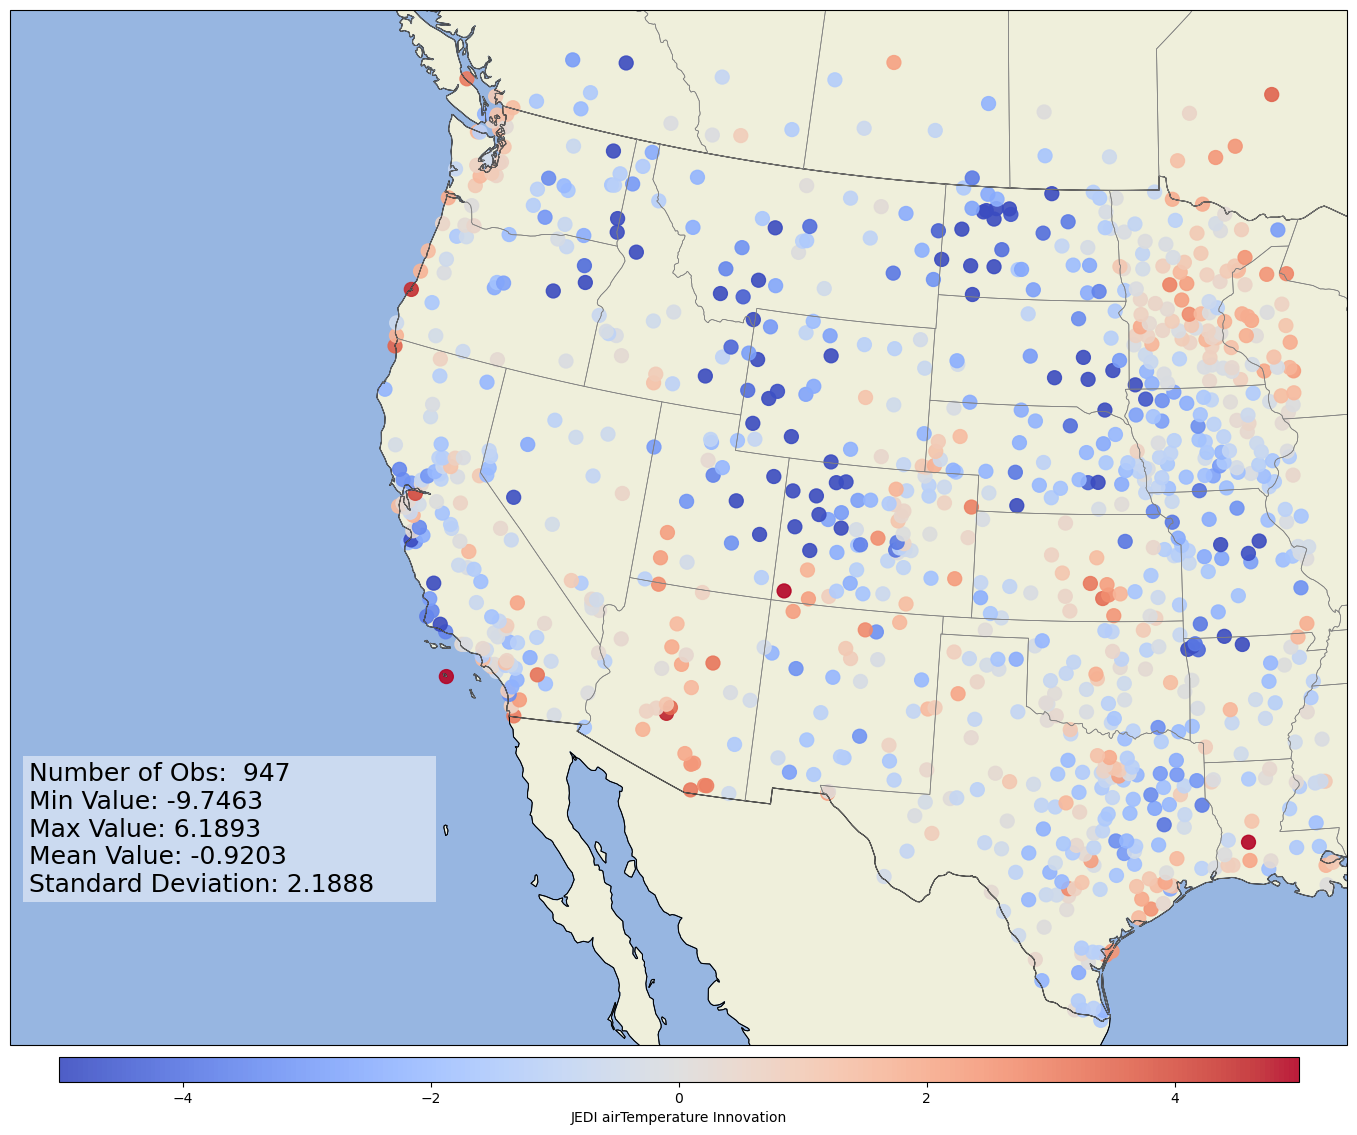

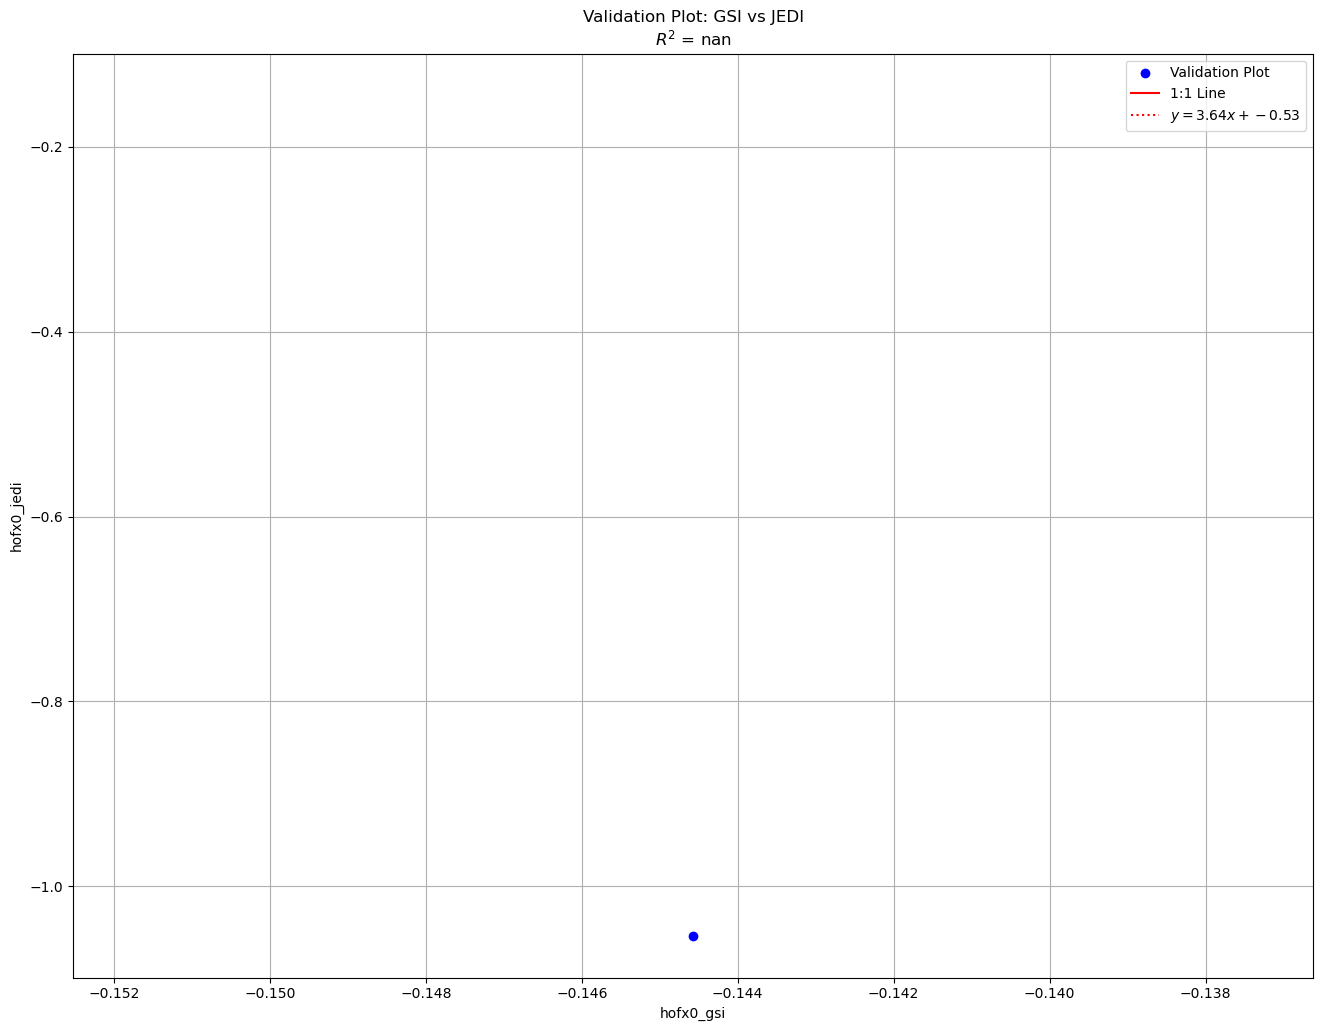

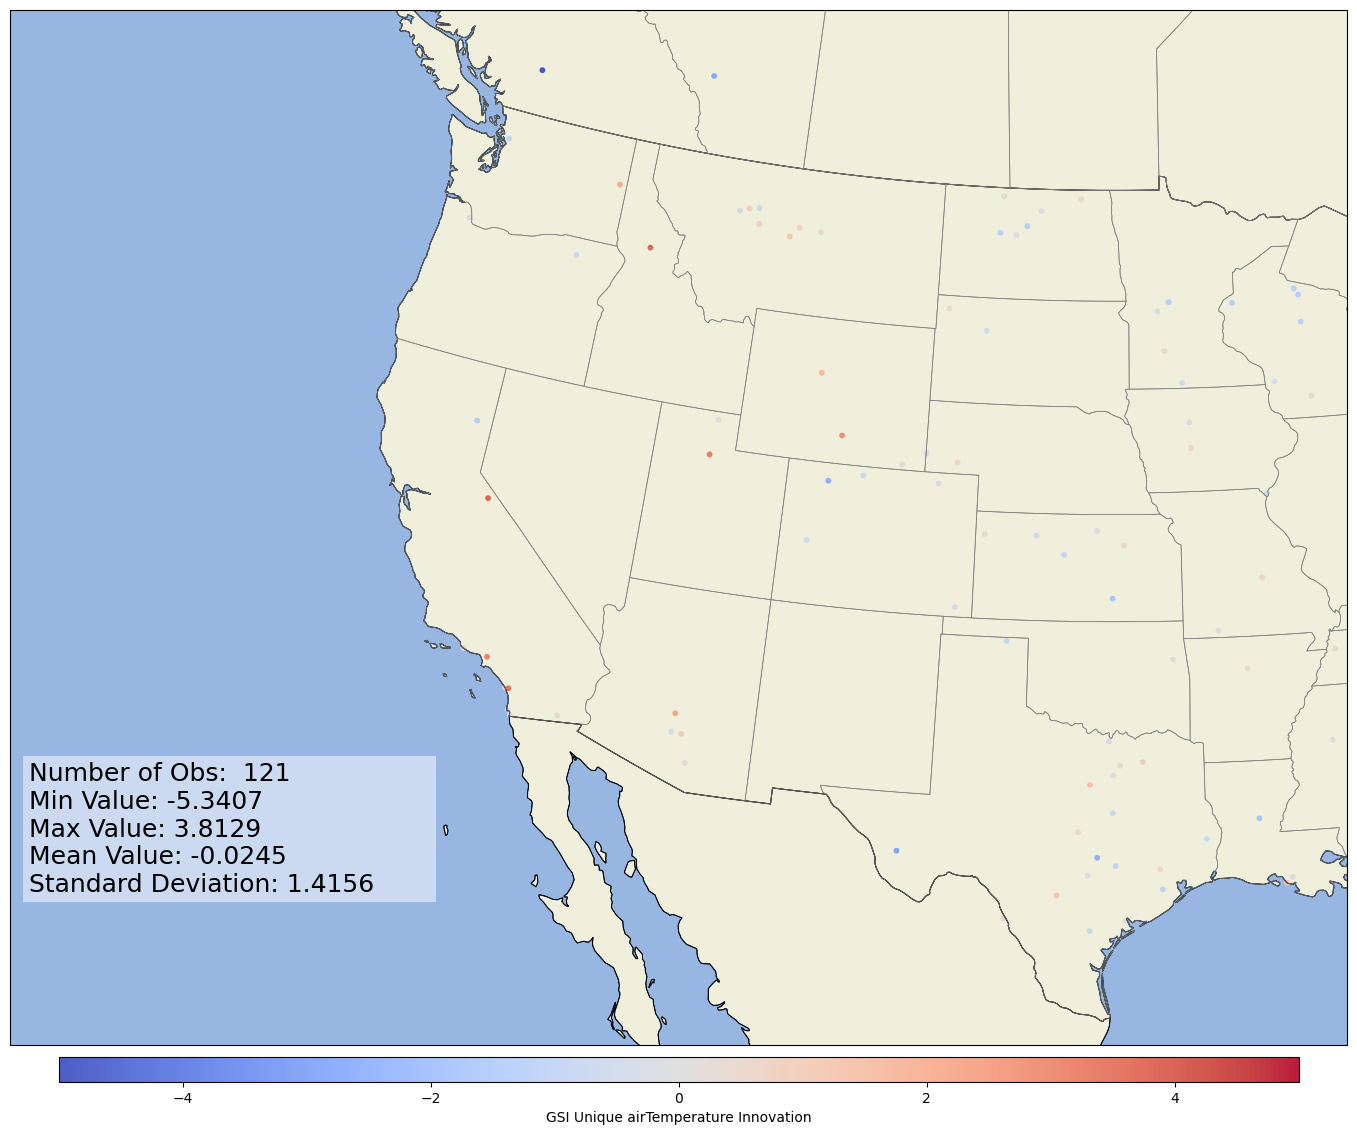

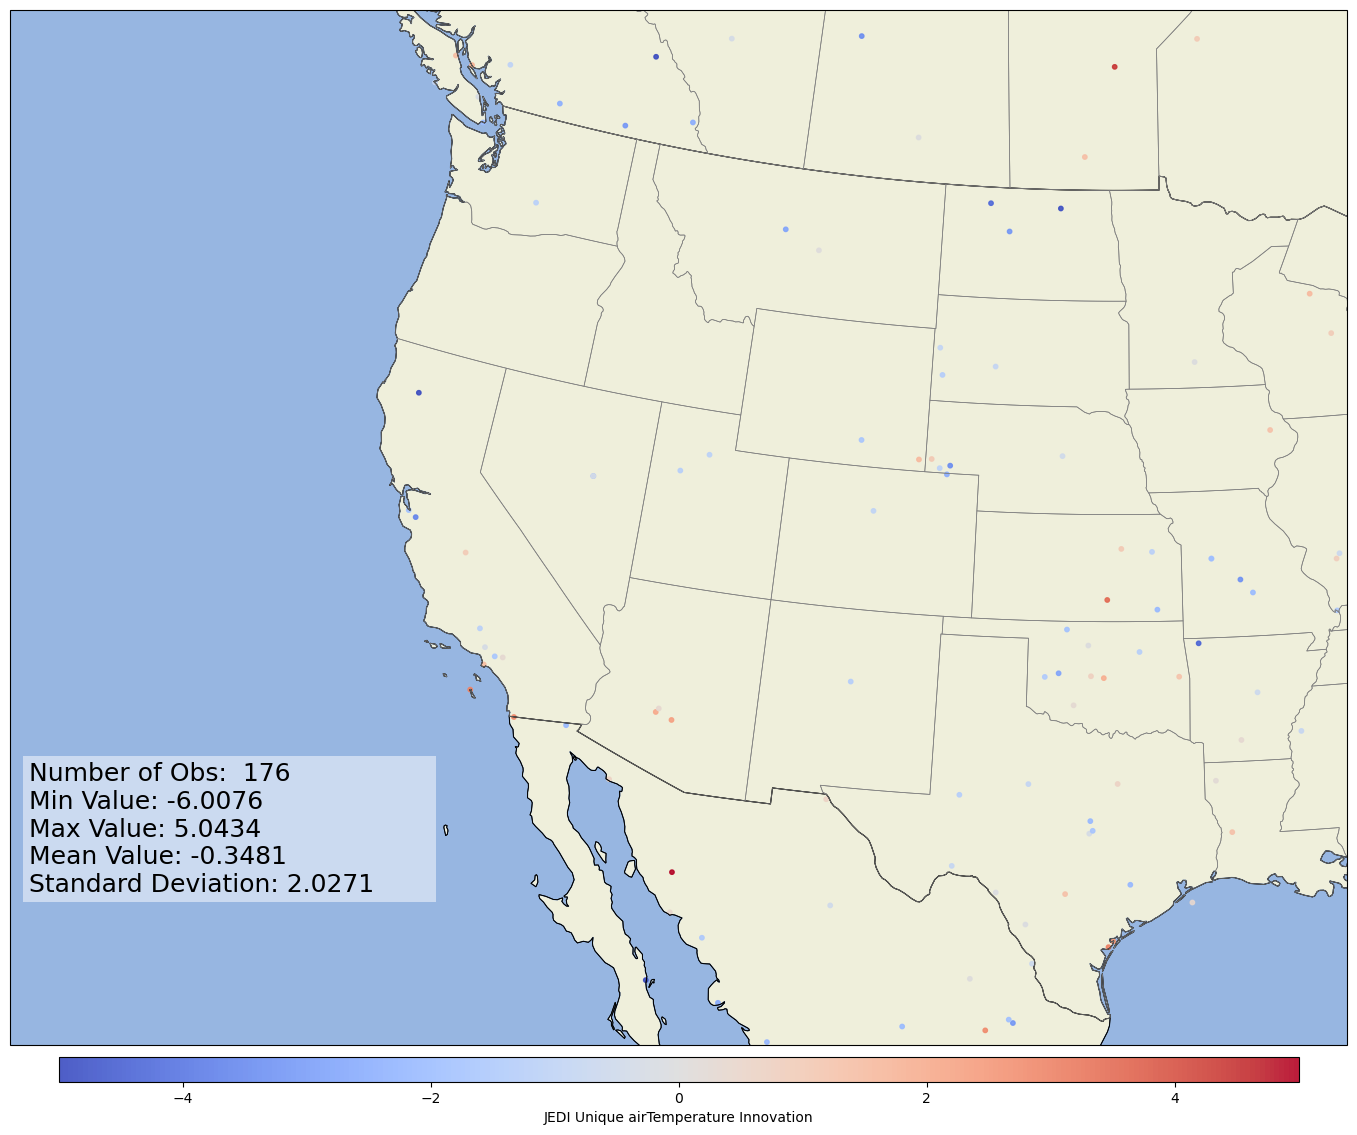

In [10]:
if __name__ == "__main__":

    gsi_lats, gsi_lons, gsi_times, gsi_press, gsi_values = read_gsi(gsi_hofx_dir, gsi_hofx_suffix, gsi_group, plot_hofx, flag=1)
    data_gsi = np.column_stack((gsi_lats, gsi_lons, gsi_times*3600, gsi_press*100, gsi_values))
    df_gsi = pd.DataFrame(data_gsi, columns=['lats', 'lons', 'times', 'press', 'values'])
    df_gsi['times'] = df_gsi['times'].round()
    df_gsi['press'] = df_gsi['press'].round()
    gsi_lats, gsi_lons, gsi_times, gsi_press, df_gsi = find_duplicates(df_gsi)
    print(f"Shape of GSI obs: {df_gsi.shape}")
    
    jedi_lats, jedi_lons, jedi_times, jedi_press, jedi_values = read_jedi(jedi_hofx_dir, jedi_hofx_filename, jedi_group, jedi_varname, flag=0)
    data_jedi = np.column_stack((jedi_lats, jedi_lons, jedi_times, jedi_press, jedi_values))
    df_jedi = pd.DataFrame(data_jedi, columns=['lats', 'lons', 'times', 'press', 'values'])
    seconds_since_epoch = (datetime.strptime(reference_time, "%Y-%m-%d_%H:%M:%S") - datetime(1970, 1, 1)).total_seconds()
    df_jedi["times"] = df_jedi["times"] - seconds_since_epoch
    jedi_lats, jedi_lons, jedi_times, jedi_press, df_jedi = find_duplicates(df_jedi)
    print(f"Shape of JEDI obs: {df_jedi.shape}")

    matched_obs, gsi_unique, jedi_unique = find_overlaps(df_gsi, df_jedi)
    
    validated_obs = obs_validation(df_gsi=df_gsi, df_jedi=df_jedi)
    
    if jedi_group == "EffectiveError0":
        matched_obs = matched_obs[(matched_obs['values_df1'] < 10**9) & (matched_obs['values_df2'] < 10**9)]
        validated_obs = validated_obs[(validated_obs['values_gsi'] < 10**9) & (validated_obs['values_jedi'] < 10**9)]

    # CONUS
    #maxlat = 58
    #minlat = 22
    #maxlon = -63
    #minlon = -131
    # W. US
    maxlat = 50
    minlat = 25
    maxlon = -90
    minlon = -131
    if jedi_group == "EffectiveError0":
        if jedi_varname == "stationPressure":
            maxval = 0.1
            minval = 0.0
        else:
            maxval = 5.0
            minval = 0.0
    elif plot_hofx or plot_innov:
        if jedi_varname == "stationPressure":
            if plot_hofx:
                maxval = 110.
                minval = 60.0
            else:
                maxval = 0.3
                minval = -0.3
        elif jedi_varname == "airTemperature":
            if plot_hofx:
                maxval = 305.
                minval = 275.
            else:
                maxval = 5.
                minval = -5.
        else:
            maxval = 6.0
            minval = -6.0
    else:
        if jedi_varname == "stationPressure":
            maxval = 110.
            minval = -110.0
        elif jedi_varname == "airTemperature":
            maxval = 305.
            minval = 275.
        elif jedi_varname == "specificHumidity":
            maxval = 20.
            minval = 0.
        else:
            maxval = 6.0
            minval = -6.0
    
    lons = matched_obs["lons"].to_numpy()
    lats = matched_obs["lats"].to_numpy()
    #differences = matched_obs["diff_values"].to_numpy()
    #variable_scatter(lons, lats, differences, colormap, markersize=10, alpha=0.9, minval=minval, maxval=maxval,
    #                 area=[minlon, maxlon, minlat, maxlat], clon=(maxlon+minlon)/2.0, clat=(minlat+maxlat)/2.0,
    #                 system="GSI - JEDI", varname=jedi_varname, vartype=jedi_group, is_hofx=plot_hofx, is_innov=plot_innov)
    variable_scatter(lons, lats, matched_obs["values_df1"].to_numpy(), colormap, markersize=10, alpha=0.9, minval=minval, maxval=maxval,
                     area=[minlon, maxlon, minlat, maxlat], clon=(maxlon+minlon)/2.0, clat=(minlat+maxlat)/2.0,
                     system="GSI", varname=jedi_varname, vartype=jedi_group, is_hofx=plot_hofx, is_innov=plot_innov)
    #variable_scatter(lons, lats, matched_obs["times_df1"].to_numpy(), colormap, markersize=10, alpha=0.9, minval=minval, maxval=maxval,
    #                 area=[minlon, maxlon, minlat, maxlat], clon=(maxlon+minlon)/2.0, clat=(minlat+maxlat)/2.0,
    #                 system="GSI", varname=jedi_varname, vartype="Observation Time", is_hofx=plot_hofx, is_innov=False)
    
    #maxval = 0.5
    #minval = -0.5
    mask = lons < 270
    #differences = matched_obs["press_df1"].to_numpy() - matched_obs["press_df2"].to_numpy()
    #variable_scatter(lons, lats, differences, colormap, markersize=10, alpha=0.9, minval=minval, maxval=maxval,
    #                 area=[minlon, maxlon, minlat, maxlat], clon=(maxlon+minlon)/2.0, clat=(minlat+maxlat)/2.0,
    #                 system="GSI - JEDI", varname="Pressure", vartype="", is_hofx=False, is_innov=plot_innov)
    variable_scatter(lons[mask], lats[mask], matched_obs["values_df2"].to_numpy()[mask], colormap, markersize=100, alpha=0.9, minval=minval, maxval=maxval,
                     area=[minlon, maxlon, minlat, maxlat], clon=(maxlon+minlon)/2.0, clat=(minlat+maxlat)/2.0,
                     system="JEDI", varname=jedi_varname, vartype=jedi_group, is_hofx=plot_hofx, is_innov=plot_innov)
    #variable_scatter(lons, lats, matched_obs["times_df2"].to_numpy(), colormap, markersize=10, alpha=0.9, minval=minval, maxval=maxval,
    #                 area=[minlon, maxlon, minlat, maxlat], clon=(maxlon+minlon)/2.0, clat=(minlat+maxlat)/2.0,
    #                 system="JEDI", varname=jedi_varname, vartype="Observation Time", is_hofx=plot_hofx, is_innov=False)
    
    valication_scatter(validated_obs, varname=jedi_varname, var_prefix=jedi_group)
    
    lons = gsi_unique["lons"].to_numpy()
    lats = gsi_unique["lats"].to_numpy()
    values = gsi_unique["values"].to_numpy()
    #values = gsi_unique["times"].to_numpy()
    if values.shape[0] > 0:
        variable_scatter(lons, lats, values, colormap, markersize=10, alpha=0.9, minval=minval, maxval=maxval,
                         area=[minlon, maxlon, minlat, maxlat], clon=(maxlon+minlon)/2.0, clat=(minlat+maxlat)/2.0,
                         system="GSI Unique", varname=jedi_varname, vartype=jedi_group, is_hofx=plot_hofx, is_innov=plot_innov)
    
    lons = jedi_unique["lons"].to_numpy()
    lats = jedi_unique["lats"].to_numpy()
    values = jedi_unique["values"].to_numpy()
    mask = lons < 260
    if values.shape[0] > 0:
        variable_scatter(lons, lats, values, colormap, markersize=10, alpha=0.9, minval=minval, maxval=maxval,
                         area=[minlon, maxlon, minlat, maxlat], clon=(maxlon+minlon)/2.0, clat=(minlat+maxlat)/2.0,
                         system="JEDI Unique", varname=jedi_varname, vartype=jedi_group, is_hofx=plot_hofx, is_innov=plot_innov)